<a href= "https://www.snapthat.ai/"> <img src="https://www.snapthat.ai/img/landing/images/logo_h1.png" /></a>

## Training T5 using Native Tensorflow 2

The purpose of this notebook is to demonstrate training using tensorflow 2 and keras. This notebook includes tf Data pipelines for build any other NLP task in a text to text fashion. Anyone can adapt the data pipeline to thier own datasets. Uses the efficient [Datasets](https://github.com/huggingface/datasets) from 🤗 as source for training.
#### Features
- Train TF T5 on SQUAD questioning and answering
- Train T5 using keras trainer fucntion
- tf.Data pipeline
- [Datasets from 🤗](https://github.com/huggingface/datasets) as source
- Log metrics using tensorboard
- Profile your experiment with the brand new tensorflow profiler !!

### Installation

Reminder: You might want to install `transformers` first and then install `transformers==3.3.1`. I had to do this a few times to get the imports correctly.

In [1]:
from IPython.display import clear_output

!pip install transformers
!pip install transformers==3.3.1
!pip install datasets==1.0.2

# clear_output()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-3.3.1-py3-none-any.whl (1.1 MB)
  Using cached tokenizers-0.8.1rc2.tar.gz (97 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached sentencepiece-0.1.99-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached sacremoses-0.0.53-py3-none-any.whl
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install py

In [2]:
from datasets import load_dataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import transformers
import datasets
from transformers import AutoTokenizer, TFT5ForConditionalGeneration
import datetime
import os
%load_ext tensorboard

In [3]:
tf_version = tf.__version__
print("Tensorflow: ", tf_version)
print("Transformers: ", transformers.__version__)
print("Datasets: ", datasets.__version__)

tf_version_split = tf_version.split('.')
assert int(tf_version_split[0])==2 and int(tf_version_split[-2])>=3, f"Tensorflow version should be '2.3+,x', given {tf_version}"


Tensorflow:  2.12.0
Transformers:  4.30.2
Datasets:  1.0.2


In [4]:
!mkdir data
!ls -la

mkdir: cannot create directory ‘data’: File exists
total 20
drwxr-xr-x 1 root root 4096 Jun 22 19:22 .
drwxr-xr-x 1 root root 4096 Jun 22 19:06 ..
drwxr-xr-x 4 root root 4096 Jun 21 21:46 .config
drwxr-xr-x 2 root root 4096 Jun 22 19:22 data
drwxr-xr-x 1 root root 4096 Jun 21 21:47 sample_data


In [5]:
data_dir = "./data"
log_dir = f"{data_dir}/experiments/t5/logs"
save_path = f"{data_dir}/experiments/t5/models"
cache_path_train = f"{data_dir}/cache/t5.train"
cache_path_test = f"{data_dir}/cache/t5.test"

### Defining the Model

In [6]:
class SnapthatT5(TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir=None, cache_dir= None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')

    @tf.function
    def train_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        with tf.GradientTape() as tape:
            outputs = self(x, training=True)
            loss = outputs[0]
            logits = outputs[1]
            loss = tf.reduce_mean(loss)

            grads = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        # lr = self.optimizer._decayed_lr(tf.float32)
        lr = 0.01

        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'lr': lr})

        return metrics

    def test_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        output = self(x, training=False)
        loss = output[0]
        loss = tf.reduce_mean(loss)
        logits = output[1]

        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        return {m.name: m.result() for m in self.metrics}


### The Tokenizer

You'll have a new model here called `T5`.

In [7]:
tokenizer = AutoTokenizer.from_pretrained("t5-base")

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


### Preparing the Data

You'll be using the same `SQUAD` dataset so you have a comparison.

In [8]:
train_dataset = load_dataset('squad', split='train')
valid_dataset = load_dataset('squad', split='validation')

train_dataset.features

Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/1244d044b266a5e4dbd4174d23cb995eead372fbca31a03edc3f8a132787af41)
Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/1244d044b266a5e4dbd4174d23cb995eead372fbca31a03edc3f8a132787af41)


{'id': Value(dtype='string', id=None),
 'title': Value(dtype='string', id=None),
 'context': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}

In [9]:
data = next(iter(train_dataset))
print("Example data from the dataset: \n", data)

Example data from the dataset: 
 {'answers': {'answer_start': [515], 'text': ['Saint Bernadette Soubirous']}, 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'id': '5733be284776f41900661182', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'title': 'University_of_Notre_Dame'}


### Training Parameters

In [10]:
warmup_steps = 1e4
batch_size = 4
encoder_max_len = 250
decoder_max_len = 54
buffer_size = 1000
ntrain = len(train_dataset)
nvalid = len(valid_dataset)
steps = int(np.ceil(ntrain/batch_size))
valid_steps = int(np.ceil(nvalid/batch_size))
print("Total Steps: ", steps)
print("Total Validation Steps: ", valid_steps)

Total Steps:  21900
Total Validation Steps:  2643


### Defining the data pipeline

In [11]:
def encode(example,
           encoder_max_len=encoder_max_len, decoder_max_len=decoder_max_len):

    context = example['context']
    question = example['question']
    answer = example['answers']['text']

    question_plus = f"answer_me: {str(question)}"
    question_plus += f" context: {str(context)} </s>"

    answer_plus = ', '.join([i for i in list(answer)])
    answer_plus = f"{answer_plus} </s>"

    encoder_inputs = tokenizer(question_plus, truncation=True,
                               return_tensors='tf', max_length=encoder_max_len,
                              pad_to_max_length=True)

    decoder_inputs = tokenizer(answer_plus, truncation=True,
                               return_tensors='tf', max_length=decoder_max_len,
                              pad_to_max_length=True)

    input_ids = encoder_inputs['input_ids'][0]
    input_attention = encoder_inputs['attention_mask'][0]
    target_ids = decoder_inputs['input_ids'][0]
    target_attention = decoder_inputs['attention_mask'][0]

    outputs = {'input_ids':input_ids, 'attention_mask': input_attention,
               'labels':target_ids, 'decoder_attention_mask':target_attention}
    return outputs



You'll need the following `dill` package so you need to run it. It might ask you to `restart` the kernel. You'll have to restart it and run everything above. I had to do this to make sure the `train_dataset.map` doesn't have error.

In [12]:
!pip install dill==0.3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
train_ds = train_dataset.map(encode)
valid_ds = valid_dataset.map(encode)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/87599 [00:00<?, ?ex/s]

  0%|          | 0/10570 [00:00<?, ?ex/s]

In [14]:
ex = next(iter(train_ds))
print("Example data from the mapped dataset: \n", ex)

Example data from the mapped dataset: 
 {'answers': {'answer_start': [515], 'text': ['Saint Bernadette Soubirous']}, 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden

In [15]:
def to_tf_dataset(dataset):
  columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']
  dataset.set_format(type='tensorflow', columns=columns)
  return_types = {'input_ids':tf.int32, 'attention_mask':tf.int32,
                'labels':tf.int32, 'decoder_attention_mask':tf.int32,  }
  return_shapes = {'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None]),
                  'labels': tf.TensorShape([None]), 'decoder_attention_mask':tf.TensorShape([None])}
  ds = tf.data.Dataset.from_generator(lambda : dataset, return_types, return_shapes)
  return ds

In [16]:
tf_train_ds = to_tf_dataset(train_ds)
tf_valid_ds = to_tf_dataset(valid_ds)

In [17]:
def create_dataset(dataset, cache_path=None, batch_size=4,
                   buffer_size= 1000, shuffling=True):
    if cache_path is not None:
        dataset = dataset.cache(cache_path)
    if shuffling:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [18]:
tf_train_ds = create_dataset(tf_train_ds, batch_size=batch_size,
                         shuffling=True, cache_path = None)
tf_valid_ds = create_dataset(tf_valid_ds, batch_size=batch_size,
                         shuffling=False, cache_path = None)

In [19]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, warmup_steps=1e4):
    super().__init__()

    self.warmup_steps = tf.cast(warmup_steps, tf.float32)

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    m = tf.maximum(self.warmup_steps, step)
    m = tf.cast(m, tf.float32)
    lr = tf.math.rsqrt(m)

    return lr


Text(0, 0.5, 'Learning rate')

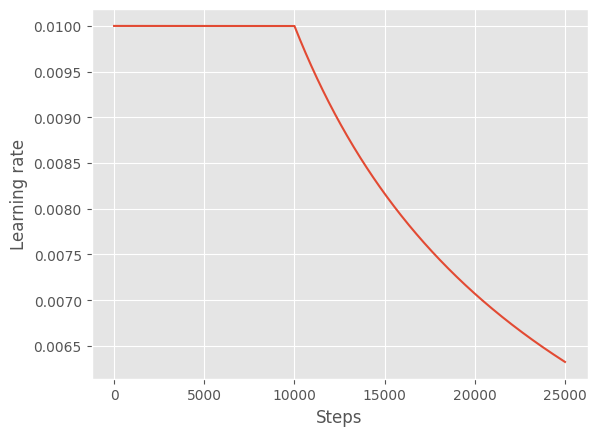

In [20]:
plt.style.use('ggplot')
schedule = CustomSchedule()
plt.plot(schedule(tf.range(25000, dtype=tf.float32)))
plt.xlabel("Steps")
plt.ylabel("Learning rate")

### Callbacks and Metrics

In [21]:
start_profile_batch = steps+10
stop_profile_batch = start_profile_batch + 100
profile_range = f"{start_profile_batch},{stop_profile_batch}"

log_path = log_dir + "/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1,
                                                     update_freq=20,profile_batch=profile_range)

checkpoint_filepath = save_path + "/" + "T5-{epoch:04d}-{val_loss:.4f}.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

callbacks = [tensorboard_callback, model_checkpoint_callback]
metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy') ]

### Training

In [22]:
# learning_rate = CustomSchedule()
learning_rate = 0.001  # Instead set a static learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate)

The `T5` model comes from [here](https://huggingface.co/t5-base) with the following related papers.

- [https://huggingface.co/papers/1805.12471](https://huggingface.co/papers/1805.12471)
- [https://huggingface.co/models?other=arxiv:1708.00055](https://huggingface.co/models?other=arxiv:1708.00055)
- [https://huggingface.co/models?other=arxiv:1704.05426](https://huggingface.co/models?other=arxiv:1704.05426)
- [https://huggingface.co/models?other=arxiv:1606.05250](https://huggingface.co/models?other=arxiv:1606.05250)
- [https://huggingface.co/models?other=arxiv:1808.09121](https://huggingface.co/models?other=arxiv:1808.09121)
-[https://huggingface.co/models?other=arxiv:1810.12885](https://huggingface.co/models?other=arxiv:1810.12885)
- [https://huggingface.co/models?other=arxiv:1905.10044](https://huggingface.co/models?other=arxiv:1905.10044)
- [https://huggingface.co/models?other=arxiv:1910.09700](https://huggingface.co/models?other=arxiv:1910.09700)
- [Exploring Transfer Learning with T5](https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html)


In [23]:
model = SnapthatT5.from_pretrained("t5-base")

All PyTorch model weights were used when initializing SnapthatT5.

Some weights or buffers of the TF 2.0 model SnapthatT5 were not initialized from the PyTorch model and are newly initialized: ['total', 'count']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model.compile(optimizer=optimizer, metrics=metrics)

In [25]:
# %tensorboard --logdir ./data/experiments/t5/logs

In [26]:
! pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.0 MB/s eta 0:00:00


In [27]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [28]:
from codecarbon import EmissionsTracker

In [29]:
epochs_done = 0
with EmissionsTracker(project_name="bert-base-uncased") as tracker:
    with tf.device('/device:GPU:0'):
        history = model.fit(tf_train_ds, epochs=1, steps_per_epoch=steps, callbacks=callbacks,
                validation_data=tf_valid_ds, validation_steps=valid_steps, initial_epoch=epochs_done)

[codecarbon INFO @ 19:40:51] [setup] RAM Tracking...
[codecarbon INFO @ 19:40:51] [setup] GPU Tracking...
[codecarbon INFO @ 19:40:51] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 19:40:51] [setup] CPU Tracking...
[codecarbon WARNING @ 19:40:51] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 19:40:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 19:40:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 19:40:52] >>> Tracker's metadata:
[codecarbon INFO @ 19:40:52]   Platform system: Linux-5.15.107+-x86_64-with-glibc2.31
[codecarbon INFO @ 19:40:52]   Python version: 3.10.12
[codecarbon INFO @ 19:40:52]   CodeCarbon version: 2.2.4
[codecarbon INFO @ 19:40:52]   Available RAM : 83.481 GB
[codecarbon INFO @ 19:40:52]   CPU count: 12
[codecarbon INFO @ 19:40:52]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 19:40:52]   GP

   32/21900 [..............................] - ETA: 41:18 - accuracy: 0.9174 - loss: 1.0112 - lr: 0.0100

[codecarbon INFO @ 19:42:22] Energy consumed for RAM : 0.000782 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:42:22] Energy consumed for all GPUs : 0.001761 kWh. Total GPU Power : 141.349 W
[codecarbon INFO @ 19:42:22] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:42:22] 0.003605 kWh of electricity used since the beginning.


  167/21900 [..............................] - ETA: 40:16 - accuracy: 0.9625 - loss: 0.4055 - lr: 0.0100

[codecarbon INFO @ 19:42:37] Energy consumed for RAM : 0.000912 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:42:37] Energy consumed for all GPUs : 0.002309 kWh. Total GPU Power : 131.651 W
[codecarbon INFO @ 19:42:37] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:42:37] 0.004461 kWh of electricity used since the beginning.


  302/21900 [..............................] - ETA: 39:59 - accuracy: 0.9637 - loss: 0.3656 - lr: 0.0100

[codecarbon INFO @ 19:42:52] Energy consumed for RAM : 0.001042 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:42:52] Energy consumed for all GPUs : 0.002769 kWh. Total GPU Power : 110.408 W


  303/21900 [..............................] - ETA: 39:59 - accuracy: 0.9637 - loss: 0.3657 - lr: 0.0100

[codecarbon INFO @ 19:42:52] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:42:52] 0.005228 kWh of electricity used since the beginning.


  437/21900 [..............................] - ETA: 39:45 - accuracy: 0.9593 - loss: 0.3901 - lr: 0.0100

[codecarbon INFO @ 19:43:07] Energy consumed for RAM : 0.001173 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:43:07] Energy consumed for all GPUs : 0.003314 kWh. Total GPU Power : 131.059 W
[codecarbon INFO @ 19:43:07] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:43:07] 0.006081 kWh of electricity used since the beginning.


  572/21900 [..............................] - ETA: 39:31 - accuracy: 0.9594 - loss: 0.3821 - lr: 0.0100

[codecarbon INFO @ 19:43:22] Energy consumed for RAM : 0.001303 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:43:22] Energy consumed for all GPUs : 0.003845 kWh. Total GPU Power : 127.40900000000002 W
[codecarbon INFO @ 19:43:22] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:43:22] 0.006918 kWh of electricity used since the beginning.


  707/21900 [..............................] - ETA: 39:14 - accuracy: 0.9621 - loss: 0.3566 - lr: 0.0100

[codecarbon INFO @ 19:43:37] Energy consumed for RAM : 0.001433 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:43:37] Energy consumed for all GPUs : 0.004378 kWh. Total GPU Power : 128.141 W


  708/21900 [..............................] - ETA: 39:14 - accuracy: 0.9621 - loss: 0.3565 - lr: 0.0100

[codecarbon INFO @ 19:43:37] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:43:37] 0.007759 kWh of electricity used since the beginning.


  842/21900 [>.............................] - ETA: 39:00 - accuracy: 0.9649 - loss: 0.3309 - lr: 0.0100

[codecarbon INFO @ 19:43:52] Energy consumed for RAM : 0.001564 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:43:52] Energy consumed for all GPUs : 0.004901 kWh. Total GPU Power : 125.414 W
[codecarbon INFO @ 19:43:52] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:43:52] 0.008589 kWh of electricity used since the beginning.


  977/21900 [>.............................] - ETA: 38:45 - accuracy: 0.9672 - loss: 0.3101 - lr: 0.0100

[codecarbon INFO @ 19:44:07] Energy consumed for RAM : 0.001694 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:44:07] Energy consumed for all GPUs : 0.005423 kWh. Total GPU Power : 125.414 W
[codecarbon INFO @ 19:44:07] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:44:07] 0.009419 kWh of electricity used since the beginning.


 1111/21900 [>.............................] - ETA: 38:32 - accuracy: 0.9697 - loss: 0.2898 - lr: 0.0100

[codecarbon INFO @ 19:44:22] Energy consumed for RAM : 0.001824 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:44:22] Energy consumed for all GPUs : 0.005949 kWh. Total GPU Power : 126.281 W
[codecarbon INFO @ 19:44:22] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:44:22] 0.010252 kWh of electricity used since the beginning.


 1245/21900 [>.............................] - ETA: 38:19 - accuracy: 0.9718 - loss: 0.2733 - lr: 0.0100

[codecarbon INFO @ 19:44:37] Energy consumed for RAM : 0.001955 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:44:37] Energy consumed for all GPUs : 0.006479 kWh. Total GPU Power : 127.40900000000002 W
[codecarbon INFO @ 19:44:37] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:44:37] 0.011090 kWh of electricity used since the beginning.


 1379/21900 [>.............................] - ETA: 38:05 - accuracy: 0.9734 - loss: 0.2611 - lr: 0.0100

[codecarbon INFO @ 19:44:52] Energy consumed for RAM : 0.002085 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:44:52] Energy consumed for all GPUs : 0.007010 kWh. Total GPU Power : 127.40900000000002 W
[codecarbon INFO @ 19:44:52] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:44:52] 0.011928 kWh of electricity used since the beginning.


 1514/21900 [=>............................] - ETA: 37:50 - accuracy: 0.9749 - loss: 0.2489 - lr: 0.0100

[codecarbon INFO @ 19:45:07] Energy consumed for RAM : 0.002215 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:45:07] Energy consumed for all GPUs : 0.007642 kWh. Total GPU Power : 151.829 W
[codecarbon INFO @ 19:45:07] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:45:07] 0.012867 kWh of electricity used since the beginning.


 1649/21900 [=>............................] - ETA: 37:35 - accuracy: 0.9764 - loss: 0.2359 - lr: 0.0100

[codecarbon INFO @ 19:45:22] Energy consumed for RAM : 0.002346 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:45:22] Energy consumed for all GPUs : 0.008206 kWh. Total GPU Power : 135.564 W
[codecarbon INFO @ 19:45:22] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:45:22] 0.013739 kWh of electricity used since the beginning.


 1784/21900 [=>............................] - ETA: 37:19 - accuracy: 0.9778 - loss: 0.2238 - lr: 0.0100

[codecarbon INFO @ 19:45:37] Energy consumed for RAM : 0.002476 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:45:37] Energy consumed for all GPUs : 0.008732 kWh. Total GPU Power : 126.413 W
[codecarbon INFO @ 19:45:37] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:45:37] 0.014572 kWh of electricity used since the beginning.


 1918/21900 [=>............................] - ETA: 37:05 - accuracy: 0.9789 - loss: 0.2142 - lr: 0.0100

[codecarbon INFO @ 19:45:52] Energy consumed for RAM : 0.002606 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:45:52] Energy consumed for all GPUs : 0.009267 kWh. Total GPU Power : 128.41 W
[codecarbon INFO @ 19:45:52] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:45:52] 0.015415 kWh of electricity used since the beginning.


 2051/21900 [=>............................] - ETA: 36:52 - accuracy: 0.9798 - loss: 0.2076 - lr: 0.0100

[codecarbon INFO @ 19:46:07] Energy consumed for RAM : 0.002736 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:46:07] Energy consumed for all GPUs : 0.009871 kWh. Total GPU Power : 145.131 W
[codecarbon INFO @ 19:46:07] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:46:07] 0.016326 kWh of electricity used since the beginning.


 2185/21900 [=>............................] - ETA: 36:38 - accuracy: 0.9806 - loss: 0.2009 - lr: 0.0100

[codecarbon INFO @ 19:46:22] Energy consumed for RAM : 0.002867 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:46:22] Energy consumed for all GPUs : 0.010620 kWh. Total GPU Power : 179.96200000000002 W
[codecarbon INFO @ 19:46:22] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:46:22] 0.017382 kWh of electricity used since the beginning.


 2319/21900 [==>...........................] - ETA: 36:23 - accuracy: 0.9813 - loss: 0.1950 - lr: 0.0100

[codecarbon INFO @ 19:46:37] Energy consumed for RAM : 0.002997 kWh. RAM Power : 31.30528450012207 W


 2320/21900 [==>...........................] - ETA: 36:23 - accuracy: 0.9813 - loss: 0.1949 - lr: 0.0100

[codecarbon INFO @ 19:46:37] Energy consumed for all GPUs : 0.011037 kWh. Total GPU Power : 100.135 W
[codecarbon INFO @ 19:46:37] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:46:37] 0.018107 kWh of electricity used since the beginning.


 2454/21900 [==>...........................] - ETA: 36:07 - accuracy: 0.9819 - loss: 0.1899 - lr: 0.0100

[codecarbon INFO @ 19:46:52] Energy consumed for RAM : 0.003127 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:46:52] Energy consumed for all GPUs : 0.011576 kWh. Total GPU Power : 129.465 W
[codecarbon INFO @ 19:46:52] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:46:52] 0.018953 kWh of electricity used since the beginning.


 2589/21900 [==>...........................] - ETA: 35:52 - accuracy: 0.9825 - loss: 0.1853 - lr: 0.0100

[codecarbon INFO @ 19:47:07] Energy consumed for RAM : 0.003258 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:47:07] Energy consumed for all GPUs : 0.012113 kWh. Total GPU Power : 128.874 W
[codecarbon INFO @ 19:47:07] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:47:07] 0.019797 kWh of electricity used since the beginning.


 2723/21900 [==>...........................] - ETA: 35:37 - accuracy: 0.9830 - loss: 0.1807 - lr: 0.0100

[codecarbon INFO @ 19:47:22] Energy consumed for RAM : 0.003388 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:47:22] Energy consumed for all GPUs : 0.012687 kWh. Total GPU Power : 137.889 W
[codecarbon INFO @ 19:47:22] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:47:22] 0.020678 kWh of electricity used since the beginning.


 2858/21900 [==>...........................] - ETA: 35:22 - accuracy: 0.9835 - loss: 0.1763 - lr: 0.0100

[codecarbon INFO @ 19:47:37] Energy consumed for RAM : 0.003518 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:47:37] Energy consumed for all GPUs : 0.013456 kWh. Total GPU Power : 184.741 W
[codecarbon INFO @ 19:47:37] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:47:37] 0.021755 kWh of electricity used since the beginning.


 2993/21900 [===>..........................] - ETA: 35:07 - accuracy: 0.9839 - loss: 0.1723 - lr: 0.0100

[codecarbon INFO @ 19:47:52] Energy consumed for RAM : 0.003649 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:47:52] Energy consumed for all GPUs : 0.013985 kWh. Total GPU Power : 127.14 W
[codecarbon INFO @ 19:47:52] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:47:52] 0.022592 kWh of electricity used since the beginning.


 3128/21900 [===>..........................] - ETA: 34:52 - accuracy: 0.9844 - loss: 0.1687 - lr: 0.0100

[codecarbon INFO @ 19:48:07] Energy consumed for RAM : 0.003779 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:48:07] Energy consumed for all GPUs : 0.014428 kWh. Total GPU Power : 106.242 W
[codecarbon INFO @ 19:48:07] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:48:07] 0.023341 kWh of electricity used since the beginning.


 3263/21900 [===>..........................] - ETA: 34:36 - accuracy: 0.9847 - loss: 0.1652 - lr: 0.0100

[codecarbon INFO @ 19:48:22] Energy consumed for RAM : 0.003909 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:48:22] Energy consumed for all GPUs : 0.014917 kWh. Total GPU Power : 117.581 W
[codecarbon INFO @ 19:48:22] Energy consumed for all CPUs : 0.005312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:48:22] 0.024138 kWh of electricity used since the beginning.


 3398/21900 [===>..........................] - ETA: 34:21 - accuracy: 0.9851 - loss: 0.1622 - lr: 0.0100

[codecarbon INFO @ 19:48:37] Energy consumed for RAM : 0.004040 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:48:37] Energy consumed for all GPUs : 0.015506 kWh. Total GPU Power : 141.349 W
[codecarbon INFO @ 19:48:37] Energy consumed for all CPUs : 0.005489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:48:37] 0.025034 kWh of electricity used since the beginning.


 3532/21900 [===>..........................] - ETA: 34:07 - accuracy: 0.9854 - loss: 0.1591 - lr: 0.0100

[codecarbon INFO @ 19:48:52] Energy consumed for RAM : 0.004170 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:48:52] Energy consumed for all GPUs : 0.015995 kWh. Total GPU Power : 117.72700000000002 W
[codecarbon INFO @ 19:48:52] Energy consumed for all CPUs : 0.005666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:48:52] 0.025831 kWh of electricity used since the beginning.


 3666/21900 [====>.........................] - ETA: 33:52 - accuracy: 0.9857 - loss: 0.1567 - lr: 0.0100

[codecarbon INFO @ 19:49:07] Energy consumed for RAM : 0.004300 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:49:07] Energy consumed for all GPUs : 0.016525 kWh. Total GPU Power : 127.14 W
[codecarbon INFO @ 19:49:07] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:49:07] 0.026668 kWh of electricity used since the beginning.


 3799/21900 [====>.........................] - ETA: 33:38 - accuracy: 0.9860 - loss: 0.1542 - lr: 0.0100

[codecarbon INFO @ 19:49:22] Energy consumed for RAM : 0.004430 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:49:22] Energy consumed for all GPUs : 0.017024 kWh. Total GPU Power : 119.906 W
[codecarbon INFO @ 19:49:22] Energy consumed for all CPUs : 0.006020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:49:22] 0.027475 kWh of electricity used since the beginning.


 3934/21900 [====>.........................] - ETA: 33:23 - accuracy: 0.9863 - loss: 0.1519 - lr: 0.0100

[codecarbon INFO @ 19:49:37] Energy consumed for RAM : 0.004561 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:49:37] Energy consumed for all GPUs : 0.017719 kWh. Total GPU Power : 166.897 W
[codecarbon INFO @ 19:49:37] Energy consumed for all CPUs : 0.006197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:49:37] 0.028477 kWh of electricity used since the beginning.


 4069/21900 [====>.........................] - ETA: 33:08 - accuracy: 0.9866 - loss: 0.1497 - lr: 0.0100

[codecarbon INFO @ 19:49:52] Energy consumed for RAM : 0.004691 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:49:52] Energy consumed for all GPUs : 0.018238 kWh. Total GPU Power : 124.54700000000001 W
[codecarbon INFO @ 19:49:52] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:49:52] 0.029303 kWh of electricity used since the beginning.


 4203/21900 [====>.........................] - ETA: 32:53 - accuracy: 0.9868 - loss: 0.1477 - lr: 0.0100

[codecarbon INFO @ 19:50:07] Energy consumed for RAM : 0.004821 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:50:07] Energy consumed for all GPUs : 0.018754 kWh. Total GPU Power : 124.22500000000002 W
[codecarbon INFO @ 19:50:07] Energy consumed for all CPUs : 0.006551 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:50:07] 0.030127 kWh of electricity used since the beginning.


 4338/21900 [====>.........................] - ETA: 32:37 - accuracy: 0.9870 - loss: 0.1460 - lr: 0.0100

[codecarbon INFO @ 19:50:22] Energy consumed for RAM : 0.004952 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:50:22] Energy consumed for all GPUs : 0.019283 kWh. Total GPU Power : 126.87200000000001 W
[codecarbon INFO @ 19:50:22] Energy consumed for all CPUs : 0.006729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:50:22] 0.030963 kWh of electricity used since the beginning.


 4473/21900 [=====>........................] - ETA: 32:22 - accuracy: 0.9871 - loss: 0.1447 - lr: 0.0100

[codecarbon INFO @ 19:50:37] Energy consumed for RAM : 0.005082 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:50:37] Energy consumed for all GPUs : 0.019809 kWh. Total GPU Power : 126.418 W
[codecarbon INFO @ 19:50:37] Energy consumed for all CPUs : 0.006906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:50:37] 0.031797 kWh of electricity used since the beginning.


 4608/21900 [=====>........................] - ETA: 32:07 - accuracy: 0.9873 - loss: 0.1436 - lr: 0.0100

[codecarbon INFO @ 19:50:52] Energy consumed for RAM : 0.005212 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:50:52] Energy consumed for all GPUs : 0.020333 kWh. Total GPU Power : 125.68300000000002 W
[codecarbon INFO @ 19:50:52] Energy consumed for all CPUs : 0.007083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:50:52] 0.032627 kWh of electricity used since the beginning.


 4743/21900 [=====>........................] - ETA: 31:52 - accuracy: 0.9873 - loss: 0.1435 - lr: 0.0100

[codecarbon INFO @ 19:51:07] Energy consumed for RAM : 0.005343 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:51:07] Energy consumed for all GPUs : 0.020754 kWh. Total GPU Power : 101.165 W
[codecarbon INFO @ 19:51:07] Energy consumed for all CPUs : 0.007260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:51:07] 0.033356 kWh of electricity used since the beginning.


 4875/21900 [=====>........................] - ETA: 31:38 - accuracy: 0.9874 - loss: 0.1431 - lr: 0.0100

[codecarbon INFO @ 19:51:22] Energy consumed for RAM : 0.005473 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:51:22] Energy consumed for all GPUs : 0.021514 kWh. Total GPU Power : 182.69400000000002 W
[codecarbon INFO @ 19:51:22] Energy consumed for all CPUs : 0.007437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:51:22] 0.034424 kWh of electricity used since the beginning.


 5010/21900 [=====>........................] - ETA: 31:23 - accuracy: 0.9875 - loss: 0.1427 - lr: 0.0100

[codecarbon INFO @ 19:51:37] Energy consumed for RAM : 0.005603 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:51:37] Energy consumed for all GPUs : 0.022051 kWh. Total GPU Power : 129.062 W
[codecarbon INFO @ 19:51:37] Energy consumed for all CPUs : 0.007614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:51:37] 0.035268 kWh of electricity used since the beginning.


 5143/21900 [======>.......................] - ETA: 31:08 - accuracy: 0.9875 - loss: 0.1420 - lr: 0.0100

[codecarbon INFO @ 19:51:52] Energy consumed for RAM : 0.005733 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:51:52] Energy consumed for all GPUs : 0.022604 kWh. Total GPU Power : 132.786 W


 5144/21900 [======>.......................] - ETA: 31:08 - accuracy: 0.9876 - loss: 0.1420 - lr: 0.0100

[codecarbon INFO @ 19:51:52] Energy consumed for all CPUs : 0.007791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:51:52] 0.036129 kWh of electricity used since the beginning.


 5278/21900 [======>.......................] - ETA: 30:53 - accuracy: 0.9877 - loss: 0.1410 - lr: 0.0100

[codecarbon INFO @ 19:52:07] Energy consumed for RAM : 0.005864 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:52:07] Energy consumed for all GPUs : 0.023052 kWh. Total GPU Power : 107.587 W
[codecarbon INFO @ 19:52:07] Energy consumed for all CPUs : 0.007968 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:52:07] 0.036884 kWh of electricity used since the beginning.


 5412/21900 [======>.......................] - ETA: 30:38 - accuracy: 0.9878 - loss: 0.1402 - lr: 0.0100

[codecarbon INFO @ 19:52:22] Energy consumed for RAM : 0.005994 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:52:22] Energy consumed for all GPUs : 0.023615 kWh. Total GPU Power : 135.242 W
[codecarbon INFO @ 19:52:22] Energy consumed for all CPUs : 0.008145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:52:22] 0.037754 kWh of electricity used since the beginning.


 5547/21900 [======>.......................] - ETA: 30:23 - accuracy: 0.9879 - loss: 0.1394 - lr: 0.0100

[codecarbon INFO @ 19:52:37] Energy consumed for RAM : 0.006124 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:52:37] Energy consumed for all GPUs : 0.024153 kWh. Total GPU Power : 129.196 W
[codecarbon INFO @ 19:52:37] Energy consumed for all CPUs : 0.008322 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:52:37] 0.038600 kWh of electricity used since the beginning.


 5682/21900 [======>.......................] - ETA: 30:08 - accuracy: 0.9880 - loss: 0.1380 - lr: 0.0100

[codecarbon INFO @ 19:52:52] Energy consumed for RAM : 0.006255 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:52:52] Energy consumed for all GPUs : 0.024660 kWh. Total GPU Power : 121.632 W
[codecarbon INFO @ 19:52:52] Energy consumed for all CPUs : 0.008499 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:52:52] 0.039414 kWh of electricity used since the beginning.


 5815/21900 [======>.......................] - ETA: 29:54 - accuracy: 0.9882 - loss: 0.1371 - lr: 0.0100

[codecarbon INFO @ 19:53:07] Energy consumed for RAM : 0.006385 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:53:07] Energy consumed for all GPUs : 0.025177 kWh. Total GPU Power : 124.417 W
[codecarbon INFO @ 19:53:07] Energy consumed for all CPUs : 0.008676 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:53:07] 0.040239 kWh of electricity used since the beginning.


 5949/21900 [=======>......................] - ETA: 29:39 - accuracy: 0.9883 - loss: 0.1361 - lr: 0.0100

[codecarbon INFO @ 19:53:22] Energy consumed for RAM : 0.006515 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:53:22] Energy consumed for all GPUs : 0.025703 kWh. Total GPU Power : 126.418 W
[codecarbon INFO @ 19:53:22] Energy consumed for all CPUs : 0.008853 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:53:22] 0.041072 kWh of electricity used since the beginning.


 6084/21900 [=======>......................] - ETA: 29:24 - accuracy: 0.9884 - loss: 0.1350 - lr: 0.0100

[codecarbon INFO @ 19:53:37] Energy consumed for RAM : 0.006645 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:53:37] Energy consumed for all GPUs : 0.026252 kWh. Total GPU Power : 131.79 W
[codecarbon INFO @ 19:53:37] Energy consumed for all CPUs : 0.009030 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:53:37] 0.041928 kWh of electricity used since the beginning.


 6219/21900 [=======>......................] - ETA: 29:08 - accuracy: 0.9885 - loss: 0.1343 - lr: 0.0100

[codecarbon INFO @ 19:53:52] Energy consumed for RAM : 0.006776 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:53:52] Energy consumed for all GPUs : 0.026802 kWh. Total GPU Power : 131.92000000000002 W
[codecarbon INFO @ 19:53:52] Energy consumed for all CPUs : 0.009207 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:53:52] 0.042785 kWh of electricity used since the beginning.


 6354/21900 [=======>......................] - ETA: 28:53 - accuracy: 0.9885 - loss: 0.1337 - lr: 0.0100

[codecarbon INFO @ 19:54:07] Energy consumed for RAM : 0.006906 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:54:07] Energy consumed for all GPUs : 0.027324 kWh. Total GPU Power : 125.55199999999999 W
[codecarbon INFO @ 19:54:07] Energy consumed for all CPUs : 0.009385 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:54:07] 0.043615 kWh of electricity used since the beginning.


 6487/21900 [=======>......................] - ETA: 28:39 - accuracy: 0.9886 - loss: 0.1329 - lr: 0.0100

[codecarbon INFO @ 19:54:22] Energy consumed for RAM : 0.007036 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:54:22] Energy consumed for all GPUs : 0.027746 kWh. Total GPU Power : 101.27 W
[codecarbon INFO @ 19:54:22] Energy consumed for all CPUs : 0.009561 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:54:22] 0.044343 kWh of electricity used since the beginning.


 6621/21900 [========>.....................] - ETA: 28:24 - accuracy: 0.9887 - loss: 0.1326 - lr: 0.0100

[codecarbon INFO @ 19:54:37] Energy consumed for RAM : 0.007167 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:54:37] Energy consumed for all GPUs : 0.028202 kWh. Total GPU Power : 109.694 W
[codecarbon INFO @ 19:54:37] Energy consumed for all CPUs : 0.009739 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:54:37] 0.045108 kWh of electricity used since the beginning.


 6757/21900 [========>.....................] - ETA: 28:08 - accuracy: 0.9888 - loss: 0.1319 - lr: 0.0100

[codecarbon INFO @ 19:54:52] Energy consumed for RAM : 0.007297 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:54:52] Energy consumed for all GPUs : 0.028844 kWh. Total GPU Power : 154.14600000000002 W
[codecarbon INFO @ 19:54:52] Energy consumed for all CPUs : 0.009916 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:54:52] 0.046057 kWh of electricity used since the beginning.


 6891/21900 [========>.....................] - ETA: 27:54 - accuracy: 0.9888 - loss: 0.1316 - lr: 0.0100

[codecarbon INFO @ 19:55:07] Energy consumed for RAM : 0.007427 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:55:07] Energy consumed for all GPUs : 0.029395 kWh. Total GPU Power : 132.242 W
[codecarbon INFO @ 19:55:07] Energy consumed for all CPUs : 0.010093 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:55:07] 0.046915 kWh of electricity used since the beginning.


 7026/21900 [========>.....................] - ETA: 27:38 - accuracy: 0.9889 - loss: 0.1307 - lr: 0.0100

[codecarbon INFO @ 19:55:22] Energy consumed for RAM : 0.007558 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:55:22] Energy consumed for all GPUs : 0.029931 kWh. Total GPU Power : 128.874 W
[codecarbon INFO @ 19:55:22] Energy consumed for all CPUs : 0.010270 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:55:22] 0.047759 kWh of electricity used since the beginning.


 7160/21900 [========>.....................] - ETA: 27:24 - accuracy: 0.9890 - loss: 0.1300 - lr: 0.0100

[codecarbon INFO @ 19:55:37] Energy consumed for RAM : 0.007688 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:55:37] Energy consumed for all GPUs : 0.030486 kWh. Total GPU Power : 133.247 W
[codecarbon INFO @ 19:55:37] Energy consumed for all CPUs : 0.010447 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:55:37] 0.048621 kWh of electricity used since the beginning.


 7295/21900 [========>.....................] - ETA: 27:08 - accuracy: 0.9890 - loss: 0.1296 - lr: 0.0100

[codecarbon INFO @ 19:55:52] Energy consumed for RAM : 0.007818 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:55:52] Energy consumed for all GPUs : 0.031017 kWh. Total GPU Power : 127.60600000000002 W
[codecarbon INFO @ 19:55:52] Energy consumed for all CPUs : 0.010624 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:55:52] 0.049460 kWh of electricity used since the beginning.


 7430/21900 [=========>....................] - ETA: 26:53 - accuracy: 0.9890 - loss: 0.1296 - lr: 0.0100

[codecarbon INFO @ 19:56:07] Energy consumed for RAM : 0.007949 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:56:07] Energy consumed for all GPUs : 0.031557 kWh. Total GPU Power : 129.598 W
[codecarbon INFO @ 19:56:07] Energy consumed for all CPUs : 0.010801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:56:07] 0.050307 kWh of electricity used since the beginning.


 7564/21900 [=========>....................] - ETA: 26:38 - accuracy: 0.9891 - loss: 0.1296 - lr: 0.0100

[codecarbon INFO @ 19:56:22] Energy consumed for RAM : 0.008079 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:56:22] Energy consumed for all GPUs : 0.032234 kWh. Total GPU Power : 162.577 W
[codecarbon INFO @ 19:56:22] Energy consumed for all CPUs : 0.010978 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:56:22] 0.051291 kWh of electricity used since the beginning.


 7695/21900 [=========>....................] - ETA: 26:24 - accuracy: 0.9891 - loss: 0.1295 - lr: 0.0100

[codecarbon INFO @ 19:56:37] Energy consumed for RAM : 0.008209 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:56:37] Energy consumed for all GPUs : 0.032748 kWh. Total GPU Power : 123.50500000000002 W


 7696/21900 [=========>....................] - ETA: 26:24 - accuracy: 0.9891 - loss: 0.1295 - lr: 0.0100

[codecarbon INFO @ 19:56:37] Energy consumed for all CPUs : 0.011155 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:56:37] 0.052113 kWh of electricity used since the beginning.


 7830/21900 [=========>....................] - ETA: 26:09 - accuracy: 0.9891 - loss: 0.1292 - lr: 0.0100

[codecarbon INFO @ 19:56:52] Energy consumed for RAM : 0.008340 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:56:52] Energy consumed for all GPUs : 0.033266 kWh. Total GPU Power : 124.417 W
[codecarbon INFO @ 19:56:52] Energy consumed for all CPUs : 0.011332 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:56:52] 0.052938 kWh of electricity used since the beginning.


 7964/21900 [=========>....................] - ETA: 25:55 - accuracy: 0.9891 - loss: 0.1289 - lr: 0.0100

[codecarbon INFO @ 19:57:07] Energy consumed for RAM : 0.008470 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:57:07] Energy consumed for all GPUs : 0.033706 kWh. Total GPU Power : 105.643 W
[codecarbon INFO @ 19:57:07] Energy consumed for all CPUs : 0.011509 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:57:07] 0.053685 kWh of electricity used since the beginning.


 8098/21900 [==========>...................] - ETA: 25:40 - accuracy: 0.9892 - loss: 0.1283 - lr: 0.0100

[codecarbon INFO @ 19:57:22] Energy consumed for RAM : 0.008600 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:57:22] Energy consumed for all GPUs : 0.034238 kWh. Total GPU Power : 127.73900000000002 W
[codecarbon INFO @ 19:57:22] Energy consumed for all CPUs : 0.011686 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:57:22] 0.054524 kWh of electricity used since the beginning.


 8233/21900 [==========>...................] - ETA: 25:25 - accuracy: 0.9893 - loss: 0.1278 - lr: 0.0100

[codecarbon INFO @ 19:57:37] Energy consumed for RAM : 0.008730 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:57:37] Energy consumed for all GPUs : 0.034768 kWh. Total GPU Power : 127.276 W
[codecarbon INFO @ 19:57:37] Energy consumed for all CPUs : 0.011863 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:57:37] 0.055361 kWh of electricity used since the beginning.


 8368/21900 [==========>...................] - ETA: 25:09 - accuracy: 0.9893 - loss: 0.1273 - lr: 0.0100

[codecarbon INFO @ 19:57:52] Energy consumed for RAM : 0.008861 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:57:52] Energy consumed for all GPUs : 0.035315 kWh. Total GPU Power : 131.513 W
[codecarbon INFO @ 19:57:52] Energy consumed for all CPUs : 0.012040 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:57:52] 0.056216 kWh of electricity used since the beginning.


 8503/21900 [==========>...................] - ETA: 24:54 - accuracy: 0.9893 - loss: 0.1278 - lr: 0.0100

[codecarbon INFO @ 19:58:07] Energy consumed for RAM : 0.008991 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:58:07] Energy consumed for all GPUs : 0.035877 kWh. Total GPU Power : 134.833 W
[codecarbon INFO @ 19:58:07] Energy consumed for all CPUs : 0.012217 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:58:07] 0.057085 kWh of electricity used since the beginning.


 8637/21900 [==========>...................] - ETA: 24:39 - accuracy: 0.9893 - loss: 0.1278 - lr: 0.0100

[codecarbon INFO @ 19:58:22] Energy consumed for RAM : 0.009121 kWh. RAM Power : 31.30528450012207 W


 8638/21900 [==========>...................] - ETA: 24:39 - accuracy: 0.9893 - loss: 0.1278 - lr: 0.0100

[codecarbon INFO @ 19:58:22] Energy consumed for all GPUs : 0.036415 kWh. Total GPU Power : 129.33000000000004 W
[codecarbon INFO @ 19:58:22] Energy consumed for all CPUs : 0.012395 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:58:22] 0.057931 kWh of electricity used since the beginning.


 8772/21900 [===========>..................] - ETA: 24:24 - accuracy: 0.9893 - loss: 0.1282 - lr: 0.0100

[codecarbon INFO @ 19:58:37] Energy consumed for RAM : 0.009252 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:58:37] Energy consumed for all GPUs : 0.036931 kWh. Total GPU Power : 123.95700000000001 W
[codecarbon INFO @ 19:58:37] Energy consumed for all CPUs : 0.012571 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:58:37] 0.058754 kWh of electricity used since the beginning.


 8907/21900 [===========>..................] - ETA: 24:09 - accuracy: 0.9892 - loss: 0.1287 - lr: 0.0100

[codecarbon INFO @ 19:58:52] Energy consumed for RAM : 0.009382 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:58:52] Energy consumed for all GPUs : 0.037444 kWh. Total GPU Power : 123.229 W
[codecarbon INFO @ 19:58:52] Energy consumed for all CPUs : 0.012749 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:58:52] 0.059574 kWh of electricity used since the beginning.


 9041/21900 [===========>..................] - ETA: 23:54 - accuracy: 0.9892 - loss: 0.1288 - lr: 0.0100

[codecarbon INFO @ 19:59:07] Energy consumed for RAM : 0.009512 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:59:07] Energy consumed for all GPUs : 0.038083 kWh. Total GPU Power : 153.395 W
[codecarbon INFO @ 19:59:07] Energy consumed for all CPUs : 0.012926 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:59:07] 0.060520 kWh of electricity used since the beginning.


 9175/21900 [===========>..................] - ETA: 23:39 - accuracy: 0.9892 - loss: 0.1290 - lr: 0.0100

[codecarbon INFO @ 19:59:22] Energy consumed for RAM : 0.009643 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:59:22] Energy consumed for all GPUs : 0.038597 kWh. Total GPU Power : 123.63400000000001 W
[codecarbon INFO @ 19:59:22] Energy consumed for all CPUs : 0.013103 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:59:22] 0.061343 kWh of electricity used since the beginning.


 9309/21900 [===========>..................] - ETA: 23:24 - accuracy: 0.9892 - loss: 0.1289 - lr: 0.0100

[codecarbon INFO @ 19:59:37] Energy consumed for RAM : 0.009773 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:59:37] Energy consumed for all GPUs : 0.039138 kWh. Total GPU Power : 129.92000000000002 W
[codecarbon INFO @ 19:59:37] Energy consumed for all CPUs : 0.013280 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:59:37] 0.062191 kWh of electricity used since the beginning.


 9444/21900 [===========>..................] - ETA: 23:09 - accuracy: 0.9892 - loss: 0.1288 - lr: 0.0100

[codecarbon INFO @ 19:59:52] Energy consumed for RAM : 0.009903 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 19:59:52] Energy consumed for all GPUs : 0.039681 kWh. Total GPU Power : 130.332 W
[codecarbon INFO @ 19:59:52] Energy consumed for all CPUs : 0.013457 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 19:59:52] 0.063041 kWh of electricity used since the beginning.


 9578/21900 [============>.................] - ETA: 22:54 - accuracy: 0.9893 - loss: 0.1283 - lr: 0.0100

[codecarbon INFO @ 20:00:07] Energy consumed for RAM : 0.010033 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:00:07] Energy consumed for all GPUs : 0.040242 kWh. Total GPU Power : 134.833 W
[codecarbon INFO @ 20:00:07] Energy consumed for all CPUs : 0.013634 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:00:07] 0.063909 kWh of electricity used since the beginning.


 9712/21900 [============>.................] - ETA: 22:39 - accuracy: 0.9893 - loss: 0.1281 - lr: 0.0100

[codecarbon INFO @ 20:00:22] Energy consumed for RAM : 0.010164 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:00:22] Energy consumed for all GPUs : 0.040771 kWh. Total GPU Power : 127.00800000000001 W
[codecarbon INFO @ 20:00:22] Energy consumed for all CPUs : 0.013811 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:00:22] 0.064746 kWh of electricity used since the beginning.


 9847/21900 [============>.................] - ETA: 22:24 - accuracy: 0.9894 - loss: 0.1279 - lr: 0.0100

[codecarbon INFO @ 20:00:37] Energy consumed for RAM : 0.010294 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:00:37] Energy consumed for all GPUs : 0.041303 kWh. Total GPU Power : 127.87400000000001 W
[codecarbon INFO @ 20:00:37] Energy consumed for all CPUs : 0.013988 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:00:37] 0.065585 kWh of electricity used since the beginning.


 9982/21900 [============>.................] - ETA: 22:09 - accuracy: 0.9894 - loss: 0.1279 - lr: 0.0100

[codecarbon INFO @ 20:00:52] Energy consumed for RAM : 0.010424 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:00:52] Energy consumed for all GPUs : 0.041835 kWh. Total GPU Power : 127.73900000000002 W
[codecarbon INFO @ 20:00:52] Energy consumed for all CPUs : 0.014165 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:00:52] 0.066425 kWh of electricity used since the beginning.


10116/21900 [============>.................] - ETA: 21:54 - accuracy: 0.9894 - loss: 0.1278 - lr: 0.0100

[codecarbon INFO @ 20:01:07] Energy consumed for RAM : 0.010555 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:01:07] Energy consumed for all GPUs : 0.042551 kWh. Total GPU Power : 171.957 W
[codecarbon INFO @ 20:01:07] Energy consumed for all CPUs : 0.014342 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:01:07] 0.067448 kWh of electricity used since the beginning.


10250/21900 [=============>................] - ETA: 21:39 - accuracy: 0.9894 - loss: 0.1277 - lr: 0.0100

[codecarbon INFO @ 20:01:22] Energy consumed for RAM : 0.010685 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:01:22] Energy consumed for all GPUs : 0.043086 kWh. Total GPU Power : 128.598 W
[codecarbon INFO @ 20:01:22] Energy consumed for all CPUs : 0.014519 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:01:22] 0.068291 kWh of electricity used since the beginning.


10383/21900 [=============>................] - ETA: 21:25 - accuracy: 0.9894 - loss: 0.1277 - lr: 0.0100

[codecarbon INFO @ 20:01:37] Energy consumed for RAM : 0.010815 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:01:37] Energy consumed for all GPUs : 0.043606 kWh. Total GPU Power : 124.82300000000001 W
[codecarbon INFO @ 20:01:37] Energy consumed for all CPUs : 0.014696 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:01:37] 0.069118 kWh of electricity used since the beginning.


10516/21900 [=============>................] - ETA: 21:10 - accuracy: 0.9895 - loss: 0.1274 - lr: 0.0100

[codecarbon INFO @ 20:01:52] Energy consumed for RAM : 0.010946 kWh. RAM Power : 31.30528450012207 W


10517/21900 [=============>................] - ETA: 21:10 - accuracy: 0.9895 - loss: 0.1274 - lr: 0.0100

[codecarbon INFO @ 20:01:52] Energy consumed for all GPUs : 0.044346 kWh. Total GPU Power : 177.64500000000004 W
[codecarbon INFO @ 20:01:52] Energy consumed for all CPUs : 0.014873 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:01:52] 0.070165 kWh of electricity used since the beginning.


10652/21900 [=============>................] - ETA: 20:55 - accuracy: 0.9894 - loss: 0.1277 - lr: 0.0100

[codecarbon INFO @ 20:02:07] Energy consumed for RAM : 0.011076 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:02:07] Energy consumed for all GPUs : 0.044802 kWh. Total GPU Power : 109.694 W
[codecarbon INFO @ 20:02:07] Energy consumed for all CPUs : 0.015050 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:02:07] 0.070928 kWh of electricity used since the beginning.


10787/21900 [=============>................] - ETA: 20:40 - accuracy: 0.9894 - loss: 0.1277 - lr: 0.0100

[codecarbon INFO @ 20:02:22] Energy consumed for RAM : 0.011206 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:02:22] Energy consumed for all GPUs : 0.045299 kWh. Total GPU Power : 119.459 W
[codecarbon INFO @ 20:02:22] Energy consumed for all CPUs : 0.015227 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:02:22] 0.071733 kWh of electricity used since the beginning.


10922/21900 [=============>................] - ETA: 20:24 - accuracy: 0.9895 - loss: 0.1276 - lr: 0.0100

[codecarbon INFO @ 20:02:37] Energy consumed for RAM : 0.011337 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:02:37] Energy consumed for all GPUs : 0.045835 kWh. Total GPU Power : 128.74 W
[codecarbon INFO @ 20:02:37] Energy consumed for all CPUs : 0.015404 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:02:37] 0.072576 kWh of electricity used since the beginning.


11057/21900 [==============>...............] - ETA: 20:09 - accuracy: 0.9895 - loss: 0.1273 - lr: 0.0100

[codecarbon INFO @ 20:02:52] Energy consumed for RAM : 0.011467 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:02:52] Energy consumed for all GPUs : 0.046360 kWh. Total GPU Power : 125.95100000000001 W
[codecarbon INFO @ 20:02:52] Energy consumed for all CPUs : 0.015582 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:02:52] 0.073408 kWh of electricity used since the beginning.


11192/21900 [==============>...............] - ETA: 19:54 - accuracy: 0.9895 - loss: 0.1273 - lr: 0.0100

[codecarbon INFO @ 20:03:07] Energy consumed for RAM : 0.011597 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:03:07] Energy consumed for all GPUs : 0.046874 kWh. Total GPU Power : 123.358 W
[codecarbon INFO @ 20:03:07] Energy consumed for all CPUs : 0.015759 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:03:07] 0.074229 kWh of electricity used since the beginning.


11326/21900 [==============>...............] - ETA: 19:39 - accuracy: 0.9895 - loss: 0.1274 - lr: 0.0100

[codecarbon INFO @ 20:03:22] Energy consumed for RAM : 0.011728 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:03:22] Energy consumed for all GPUs : 0.047309 kWh. Total GPU Power : 104.50800000000001 W
[codecarbon INFO @ 20:03:22] Energy consumed for all CPUs : 0.015936 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:03:22] 0.074972 kWh of electricity used since the beginning.


11461/21900 [==============>...............] - ETA: 19:24 - accuracy: 0.9895 - loss: 0.1276 - lr: 0.0100

[codecarbon INFO @ 20:03:37] Energy consumed for RAM : 0.011858 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:03:37] Energy consumed for all GPUs : 0.047812 kWh. Total GPU Power : 120.77300000000001 W
[codecarbon INFO @ 20:03:37] Energy consumed for all CPUs : 0.016113 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:03:37] 0.075782 kWh of electricity used since the beginning.


11594/21900 [==============>...............] - ETA: 19:09 - accuracy: 0.9895 - loss: 0.1274 - lr: 0.0100

[codecarbon INFO @ 20:03:52] Energy consumed for RAM : 0.011988 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:03:52] Energy consumed for all GPUs : 0.048310 kWh. Total GPU Power : 119.583 W
[codecarbon INFO @ 20:03:52] Energy consumed for all CPUs : 0.016290 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:03:52] 0.076588 kWh of electricity used since the beginning.


11728/21900 [===============>..............] - ETA: 18:55 - accuracy: 0.9895 - loss: 0.1278 - lr: 0.0100

[codecarbon INFO @ 20:04:07] Energy consumed for RAM : 0.012119 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:04:07] Energy consumed for all GPUs : 0.049039 kWh. Total GPU Power : 175.052 W
[codecarbon INFO @ 20:04:07] Energy consumed for all CPUs : 0.016467 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:04:07] 0.077624 kWh of electricity used since the beginning.


11862/21900 [===============>..............] - ETA: 18:40 - accuracy: 0.9895 - loss: 0.1280 - lr: 0.0100

[codecarbon INFO @ 20:04:22] Energy consumed for RAM : 0.012249 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:04:22] Energy consumed for all GPUs : 0.049611 kWh. Total GPU Power : 137.56700000000004 W
[codecarbon INFO @ 20:04:22] Energy consumed for all CPUs : 0.016644 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:04:22] 0.078504 kWh of electricity used since the beginning.


11997/21900 [===============>..............] - ETA: 18:24 - accuracy: 0.9894 - loss: 0.1285 - lr: 0.0100

[codecarbon INFO @ 20:04:37] Energy consumed for RAM : 0.012379 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:04:37] Energy consumed for all GPUs : 0.050162 kWh. Total GPU Power : 132.242 W
[codecarbon INFO @ 20:04:37] Energy consumed for all CPUs : 0.016821 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:04:37] 0.079362 kWh of electricity used since the beginning.


12132/21900 [===============>..............] - ETA: 18:09 - accuracy: 0.9894 - loss: 0.1289 - lr: 0.0100

[codecarbon INFO @ 20:04:52] Energy consumed for RAM : 0.012510 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:04:52] Energy consumed for all GPUs : 0.050865 kWh. Total GPU Power : 168.769 W
[codecarbon INFO @ 20:04:52] Energy consumed for all CPUs : 0.016998 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:04:52] 0.080372 kWh of electricity used since the beginning.


12267/21900 [===============>..............] - ETA: 17:54 - accuracy: 0.9894 - loss: 0.1292 - lr: 0.0100

[codecarbon INFO @ 20:05:07] Energy consumed for RAM : 0.012640 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:05:07] Energy consumed for all GPUs : 0.051395 kWh. Total GPU Power : 127.276 W
[codecarbon INFO @ 20:05:07] Energy consumed for all CPUs : 0.017175 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:05:07] 0.081210 kWh of electricity used since the beginning.


12401/21900 [===============>..............] - ETA: 17:39 - accuracy: 0.9894 - loss: 0.1291 - lr: 0.0100

[codecarbon INFO @ 20:05:22] Energy consumed for RAM : 0.012770 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:05:22] Energy consumed for all GPUs : 0.051925 kWh. Total GPU Power : 127.40900000000002 W
[codecarbon INFO @ 20:05:22] Energy consumed for all CPUs : 0.017352 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:05:22] 0.082048 kWh of electricity used since the beginning.


12535/21900 [================>.............] - ETA: 17:24 - accuracy: 0.9894 - loss: 0.1289 - lr: 0.0100

[codecarbon INFO @ 20:05:37] Energy consumed for RAM : 0.012901 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:05:37] Energy consumed for all GPUs : 0.052442 kWh. Total GPU Power : 124.095 W


12536/21900 [================>.............] - ETA: 17:24 - accuracy: 0.9894 - loss: 0.1289 - lr: 0.0100

[codecarbon INFO @ 20:05:37] Energy consumed for all CPUs : 0.017529 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:05:37] 0.082872 kWh of electricity used since the beginning.


12671/21900 [================>.............] - ETA: 17:09 - accuracy: 0.9894 - loss: 0.1289 - lr: 0.0100

[codecarbon INFO @ 20:05:52] Energy consumed for RAM : 0.013031 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:05:52] Energy consumed for all GPUs : 0.052987 kWh. Total GPU Power : 131.054 W
[codecarbon INFO @ 20:05:52] Energy consumed for all CPUs : 0.017706 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:05:52] 0.083724 kWh of electricity used since the beginning.


12805/21900 [================>.............] - ETA: 16:54 - accuracy: 0.9894 - loss: 0.1287 - lr: 0.0100

[codecarbon INFO @ 20:06:07] Energy consumed for RAM : 0.013161 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:06:07] Energy consumed for all GPUs : 0.053513 kWh. Total GPU Power : 126.418 W
[codecarbon INFO @ 20:06:07] Energy consumed for all CPUs : 0.017883 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:06:07] 0.084557 kWh of electricity used since the beginning.


12940/21900 [================>.............] - ETA: 16:39 - accuracy: 0.9895 - loss: 0.1284 - lr: 0.0100

[codecarbon INFO @ 20:06:22] Energy consumed for RAM : 0.013291 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:06:22] Energy consumed for all GPUs : 0.054007 kWh. Total GPU Power : 118.593 W
[codecarbon INFO @ 20:06:22] Energy consumed for all CPUs : 0.018060 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:06:22] 0.085359 kWh of electricity used since the beginning.


13074/21900 [================>.............] - ETA: 16:24 - accuracy: 0.9895 - loss: 0.1282 - lr: 0.0100

[codecarbon INFO @ 20:06:37] Energy consumed for RAM : 0.013422 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:06:37] Energy consumed for all GPUs : 0.054461 kWh. Total GPU Power : 109.15700000000001 W
[codecarbon INFO @ 20:06:37] Energy consumed for all CPUs : 0.018237 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:06:37] 0.086121 kWh of electricity used since the beginning.


13206/21900 [=================>............] - ETA: 16:10 - accuracy: 0.9895 - loss: 0.1284 - lr: 0.0100

[codecarbon INFO @ 20:06:52] Energy consumed for RAM : 0.013552 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:06:52] Energy consumed for all GPUs : 0.054901 kWh. Total GPU Power : 105.643 W
[codecarbon INFO @ 20:06:52] Energy consumed for all CPUs : 0.018415 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:06:52] 0.086868 kWh of electricity used since the beginning.


13340/21900 [=================>............] - ETA: 15:55 - accuracy: 0.9895 - loss: 0.1285 - lr: 0.0100

[codecarbon INFO @ 20:07:07] Energy consumed for RAM : 0.013682 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:07:07] Energy consumed for all GPUs : 0.055451 kWh. Total GPU Power : 132.05800000000002 W
[codecarbon INFO @ 20:07:07] Energy consumed for all CPUs : 0.018592 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:07:07] 0.087725 kWh of electricity used since the beginning.


13473/21900 [=================>............] - ETA: 15:40 - accuracy: 0.9895 - loss: 0.1288 - lr: 0.0100

[codecarbon INFO @ 20:07:22] Energy consumed for RAM : 0.013813 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:07:22] Energy consumed for all GPUs : 0.055984 kWh. Total GPU Power : 128.007 W
[codecarbon INFO @ 20:07:22] Energy consumed for all CPUs : 0.018769 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:07:22] 0.088565 kWh of electricity used since the beginning.


13608/21900 [=================>............] - ETA: 15:25 - accuracy: 0.9895 - loss: 0.1289 - lr: 0.0100

[codecarbon INFO @ 20:07:37] Energy consumed for RAM : 0.013943 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:07:37] Energy consumed for all GPUs : 0.056501 kWh. Total GPU Power : 124.22500000000002 W
[codecarbon INFO @ 20:07:37] Energy consumed for all CPUs : 0.018946 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:07:37] 0.089390 kWh of electricity used since the beginning.


13743/21900 [=================>............] - ETA: 15:10 - accuracy: 0.9895 - loss: 0.1289 - lr: 0.0100

[codecarbon INFO @ 20:07:52] Energy consumed for RAM : 0.014073 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:07:52] Energy consumed for all GPUs : 0.057022 kWh. Total GPU Power : 125.09200000000001 W
[codecarbon INFO @ 20:07:52] Energy consumed for all CPUs : 0.019123 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:07:52] 0.090218 kWh of electricity used since the beginning.


13878/21900 [==================>...........] - ETA: 14:55 - accuracy: 0.9895 - loss: 0.1290 - lr: 0.0100

[codecarbon INFO @ 20:08:07] Energy consumed for RAM : 0.014204 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:08:07] Energy consumed for all GPUs : 0.057588 kWh. Total GPU Power : 135.84 W
[codecarbon INFO @ 20:08:07] Energy consumed for all CPUs : 0.019300 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:08:07] 0.091091 kWh of electricity used since the beginning.


14012/21900 [==================>...........] - ETA: 14:40 - accuracy: 0.9895 - loss: 0.1291 - lr: 0.0100

[codecarbon INFO @ 20:08:22] Energy consumed for RAM : 0.014334 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:08:22] Energy consumed for all GPUs : 0.058087 kWh. Total GPU Power : 119.906 W
[codecarbon INFO @ 20:08:22] Energy consumed for all CPUs : 0.019477 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:08:22] 0.091898 kWh of electricity used since the beginning.


14147/21900 [==================>...........] - ETA: 14:25 - accuracy: 0.9895 - loss: 0.1293 - lr: 0.0100

[codecarbon INFO @ 20:08:37] Energy consumed for RAM : 0.014464 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:08:37] Energy consumed for all GPUs : 0.058625 kWh. Total GPU Power : 129.062 W
[codecarbon INFO @ 20:08:37] Energy consumed for all CPUs : 0.019654 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:08:37] 0.092743 kWh of electricity used since the beginning.


14281/21900 [==================>...........] - ETA: 14:10 - accuracy: 0.9895 - loss: 0.1294 - lr: 0.0100

[codecarbon INFO @ 20:08:52] Energy consumed for RAM : 0.014595 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:08:52] Energy consumed for all GPUs : 0.059060 kWh. Total GPU Power : 104.50800000000001 W
[codecarbon INFO @ 20:08:52] Energy consumed for all CPUs : 0.019831 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:08:52] 0.093485 kWh of electricity used since the beginning.


14415/21900 [==================>...........] - ETA: 13:55 - accuracy: 0.9894 - loss: 0.1295 - lr: 0.0100

[codecarbon INFO @ 20:09:07] Energy consumed for RAM : 0.014725 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:09:07] Energy consumed for all GPUs : 0.059586 kWh. Total GPU Power : 126.55 W
[codecarbon INFO @ 20:09:07] Energy consumed for all CPUs : 0.020008 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:09:07] 0.094319 kWh of electricity used since the beginning.


14550/21900 [==================>...........] - ETA: 13:40 - accuracy: 0.9894 - loss: 0.1296 - lr: 0.0100

[codecarbon INFO @ 20:09:22] Energy consumed for RAM : 0.014855 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:09:22] Energy consumed for all GPUs : 0.060244 kWh. Total GPU Power : 157.92800000000003 W
[codecarbon INFO @ 20:09:22] Energy consumed for all CPUs : 0.020185 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:09:22] 0.095284 kWh of electricity used since the beginning.


14685/21900 [===================>..........] - ETA: 13:25 - accuracy: 0.9894 - loss: 0.1296 - lr: 0.0100

[codecarbon INFO @ 20:09:37] Energy consumed for RAM : 0.014986 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:09:37] Energy consumed for all GPUs : 0.060659 kWh. Total GPU Power : 99.544 W
[codecarbon INFO @ 20:09:37] Energy consumed for all CPUs : 0.020362 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:09:37] 0.096006 kWh of electricity used since the beginning.


14819/21900 [===================>..........] - ETA: 13:10 - accuracy: 0.9895 - loss: 0.1294 - lr: 0.0100

[codecarbon INFO @ 20:09:52] Energy consumed for RAM : 0.015116 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:09:52] Energy consumed for all GPUs : 0.061198 kWh. Total GPU Power : 129.465 W
[codecarbon INFO @ 20:09:52] Energy consumed for all CPUs : 0.020539 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:09:52] 0.096853 kWh of electricity used since the beginning.


14954/21900 [===================>..........] - ETA: 12:55 - accuracy: 0.9895 - loss: 0.1291 - lr: 0.0100

[codecarbon INFO @ 20:10:07] Energy consumed for RAM : 0.015246 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:10:07] Energy consumed for all GPUs : 0.061797 kWh. Total GPU Power : 143.996 W
[codecarbon INFO @ 20:10:07] Energy consumed for all CPUs : 0.020716 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:10:07] 0.097760 kWh of electricity used since the beginning.


15088/21900 [===================>..........] - ETA: 12:40 - accuracy: 0.9895 - loss: 0.1288 - lr: 0.0100

[codecarbon INFO @ 20:10:22] Energy consumed for RAM : 0.015376 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:10:22] Energy consumed for all GPUs : 0.062558 kWh. Total GPU Power : 182.69400000000002 W
[codecarbon INFO @ 20:10:22] Energy consumed for all CPUs : 0.020893 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:10:22] 0.098828 kWh of electricity used since the beginning.


15222/21900 [===================>..........] - ETA: 12:25 - accuracy: 0.9896 - loss: 0.1284 - lr: 0.0100

[codecarbon INFO @ 20:10:37] Energy consumed for RAM : 0.015507 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:10:37] Energy consumed for all GPUs : 0.063133 kWh. Total GPU Power : 138.157 W
[codecarbon INFO @ 20:10:37] Energy consumed for all CPUs : 0.021070 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:10:37] 0.099710 kWh of electricity used since the beginning.


15357/21900 [====================>.........] - ETA: 12:10 - accuracy: 0.9896 - loss: 0.1281 - lr: 0.0100

[codecarbon INFO @ 20:10:52] Energy consumed for RAM : 0.015637 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:10:52] Energy consumed for all GPUs : 0.063649 kWh. Total GPU Power : 123.95700000000001 W
[codecarbon INFO @ 20:10:52] Energy consumed for all CPUs : 0.021248 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:10:52] 0.100534 kWh of electricity used since the beginning.


15491/21900 [====================>.........] - ETA: 11:55 - accuracy: 0.9896 - loss: 0.1278 - lr: 0.0100

[codecarbon INFO @ 20:11:07] Energy consumed for RAM : 0.015767 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:11:07] Energy consumed for all GPUs : 0.064212 kWh. Total GPU Power : 135.101 W
[codecarbon INFO @ 20:11:07] Energy consumed for all CPUs : 0.021425 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:11:07] 0.101404 kWh of electricity used since the beginning.


15625/21900 [====================>.........] - ETA: 11:40 - accuracy: 0.9896 - loss: 0.1278 - lr: 0.0100

[codecarbon INFO @ 20:11:22] Energy consumed for RAM : 0.015898 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:11:22] Energy consumed for all GPUs : 0.064751 kWh. Total GPU Power : 129.598 W
[codecarbon INFO @ 20:11:22] Energy consumed for all CPUs : 0.021602 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:11:22] 0.102251 kWh of electricity used since the beginning.


15759/21900 [====================>.........] - ETA: 11:25 - accuracy: 0.9896 - loss: 0.1277 - lr: 0.0100

[codecarbon INFO @ 20:11:37] Energy consumed for RAM : 0.016028 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:11:37] Energy consumed for all GPUs : 0.065284 kWh. Total GPU Power : 127.87400000000001 W
[codecarbon INFO @ 20:11:37] Energy consumed for all CPUs : 0.021779 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:11:37] 0.103091 kWh of electricity used since the beginning.


15893/21900 [====================>.........] - ETA: 11:10 - accuracy: 0.9896 - loss: 0.1276 - lr: 0.0100

[codecarbon INFO @ 20:11:52] Energy consumed for RAM : 0.016158 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:11:52] Energy consumed for all GPUs : 0.065734 kWh. Total GPU Power : 108.23700000000001 W
[codecarbon INFO @ 20:11:52] Energy consumed for all CPUs : 0.021956 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:11:52] 0.103849 kWh of electricity used since the beginning.


16025/21900 [====================>.........] - ETA: 10:55 - accuracy: 0.9897 - loss: 0.1274 - lr: 0.0100

[codecarbon INFO @ 20:12:07] Energy consumed for RAM : 0.016289 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:12:07] Energy consumed for all GPUs : 0.066158 kWh. Total GPU Power : 101.593 W
[codecarbon INFO @ 20:12:07] Energy consumed for all CPUs : 0.022133 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:12:07] 0.104579 kWh of electricity used since the beginning.


16160/21900 [=====================>........] - ETA: 10:40 - accuracy: 0.9897 - loss: 0.1273 - lr: 0.0100

[codecarbon INFO @ 20:12:22] Energy consumed for RAM : 0.016419 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:12:22] Energy consumed for all GPUs : 0.066616 kWh. Total GPU Power : 110.024 W
[codecarbon INFO @ 20:12:22] Energy consumed for all CPUs : 0.022310 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:12:22] 0.105345 kWh of electricity used since the beginning.


16295/21900 [=====================>........] - ETA: 10:25 - accuracy: 0.9897 - loss: 0.1271 - lr: 0.0100

[codecarbon INFO @ 20:12:37] Energy consumed for RAM : 0.016549 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:12:37] Energy consumed for all GPUs : 0.067133 kWh. Total GPU Power : 124.22500000000002 W
[codecarbon INFO @ 20:12:37] Energy consumed for all CPUs : 0.022487 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:12:37] 0.106169 kWh of electricity used since the beginning.


16430/21900 [=====================>........] - ETA: 10:10 - accuracy: 0.9897 - loss: 0.1270 - lr: 0.0100

[codecarbon INFO @ 20:12:52] Energy consumed for RAM : 0.016680 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:12:52] Energy consumed for all GPUs : 0.067656 kWh. Total GPU Power : 125.55199999999999 W
[codecarbon INFO @ 20:12:52] Energy consumed for all CPUs : 0.022664 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:12:52] 0.107000 kWh of electricity used since the beginning.


16565/21900 [=====================>........] - ETA: 9:55 - accuracy: 0.9897 - loss: 0.1269 - lr: 0.0100

[codecarbon INFO @ 20:13:07] Energy consumed for RAM : 0.016810 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:13:07] Energy consumed for all GPUs : 0.068203 kWh. Total GPU Power : 131.37600000000003 W
[codecarbon INFO @ 20:13:07] Energy consumed for all CPUs : 0.022841 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:13:07] 0.107854 kWh of electricity used since the beginning.


16699/21900 [=====================>........] - ETA: 9:40 - accuracy: 0.9897 - loss: 0.1269 - lr: 0.0100

[codecarbon INFO @ 20:13:22] Energy consumed for RAM : 0.016940 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:13:22] Energy consumed for all GPUs : 0.068686 kWh. Total GPU Power : 116.002 W


16700/21900 [=====================>........] - ETA: 9:40 - accuracy: 0.9897 - loss: 0.1269 - lr: 0.0100

[codecarbon INFO @ 20:13:22] Energy consumed for all CPUs : 0.023018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:13:22] 0.108644 kWh of electricity used since the beginning.


16834/21900 [======================>.......] - ETA: 9:25 - accuracy: 0.9897 - loss: 0.1268 - lr: 0.0100

[codecarbon INFO @ 20:13:37] Energy consumed for RAM : 0.017071 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:13:37] Energy consumed for all GPUs : 0.069128 kWh. Total GPU Power : 106.242 W
[codecarbon INFO @ 20:13:37] Energy consumed for all CPUs : 0.023195 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:13:37] 0.109394 kWh of electricity used since the beginning.


16967/21900 [======================>.......] - ETA: 9:10 - accuracy: 0.9897 - loss: 0.1267 - lr: 0.0100

[codecarbon INFO @ 20:13:52] Energy consumed for RAM : 0.017201 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:13:52] Energy consumed for all GPUs : 0.069675 kWh. Total GPU Power : 131.513 W


16968/21900 [======================>.......] - ETA: 9:10 - accuracy: 0.9897 - loss: 0.1267 - lr: 0.0100

[codecarbon INFO @ 20:13:52] Energy consumed for all CPUs : 0.023372 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:13:52] 0.110249 kWh of electricity used since the beginning.


17100/21900 [======================>.......] - ETA: 8:55 - accuracy: 0.9898 - loss: 0.1266 - lr: 0.0100

[codecarbon INFO @ 20:14:07] Energy consumed for RAM : 0.017331 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:14:07] Energy consumed for all GPUs : 0.070284 kWh. Total GPU Power : 146.16000000000003 W
[codecarbon INFO @ 20:14:07] Energy consumed for all CPUs : 0.023549 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:14:07] 0.111164 kWh of electricity used since the beginning.


17235/21900 [======================>.......] - ETA: 8:40 - accuracy: 0.9898 - loss: 0.1267 - lr: 0.0100

[codecarbon INFO @ 20:14:22] Energy consumed for RAM : 0.017462 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:14:22] Energy consumed for all GPUs : 0.071015 kWh. Total GPU Power : 175.72800000000004 W
[codecarbon INFO @ 20:14:22] Energy consumed for all CPUs : 0.023726 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:14:22] 0.112203 kWh of electricity used since the beginning.


17370/21900 [======================>.......] - ETA: 8:25 - accuracy: 0.9897 - loss: 0.1269 - lr: 0.0100

[codecarbon INFO @ 20:14:37] Energy consumed for RAM : 0.017592 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:14:37] Energy consumed for all GPUs : 0.071489 kWh. Total GPU Power : 113.68 W
[codecarbon INFO @ 20:14:37] Energy consumed for all CPUs : 0.023904 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:14:37] 0.112984 kWh of electricity used since the beginning.


17504/21900 [======================>.......] - ETA: 8:10 - accuracy: 0.9897 - loss: 0.1273 - lr: 0.0100

[codecarbon INFO @ 20:14:52] Energy consumed for RAM : 0.017722 kWh. RAM Power : 31.30528450012207 W


17505/21900 [======================>.......] - ETA: 8:10 - accuracy: 0.9897 - loss: 0.1273 - lr: 0.0100

[codecarbon INFO @ 20:14:52] Energy consumed for all GPUs : 0.072012 kWh. Total GPU Power : 125.55199999999999 W
[codecarbon INFO @ 20:14:52] Energy consumed for all CPUs : 0.024081 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:14:52] 0.113815 kWh of electricity used since the beginning.


17640/21900 [=======================>......] - ETA: 7:55 - accuracy: 0.9897 - loss: 0.1274 - lr: 0.0100

[codecarbon INFO @ 20:15:07] Energy consumed for RAM : 0.017853 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:15:07] Energy consumed for all GPUs : 0.072538 kWh. Total GPU Power : 126.55 W
[codecarbon INFO @ 20:15:07] Energy consumed for all CPUs : 0.024258 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:15:07] 0.114649 kWh of electricity used since the beginning.


17774/21900 [=======================>......] - ETA: 7:40 - accuracy: 0.9897 - loss: 0.1276 - lr: 0.0100

[codecarbon INFO @ 20:15:22] Energy consumed for RAM : 0.017983 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:15:22] Energy consumed for all GPUs : 0.073067 kWh. Total GPU Power : 127.14 W
[codecarbon INFO @ 20:15:22] Energy consumed for all CPUs : 0.024435 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:15:22] 0.115485 kWh of electricity used since the beginning.


17909/21900 [=======================>......] - ETA: 7:25 - accuracy: 0.9897 - loss: 0.1276 - lr: 0.0100

[codecarbon INFO @ 20:15:37] Energy consumed for RAM : 0.018113 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:15:37] Energy consumed for all GPUs : 0.073619 kWh. Total GPU Power : 132.518 W
[codecarbon INFO @ 20:15:37] Energy consumed for all CPUs : 0.024612 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:15:37] 0.116344 kWh of electricity used since the beginning.


18043/21900 [=======================>......] - ETA: 7:10 - accuracy: 0.9897 - loss: 0.1276 - lr: 0.0100

[codecarbon INFO @ 20:15:52] Energy consumed for RAM : 0.018243 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:15:52] Energy consumed for all GPUs : 0.074088 kWh. Total GPU Power : 112.61 W
[codecarbon INFO @ 20:15:52] Energy consumed for all CPUs : 0.024789 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:15:52] 0.117120 kWh of electricity used since the beginning.


18177/21900 [=======================>......] - ETA: 6:55 - accuracy: 0.9897 - loss: 0.1277 - lr: 0.0100

[codecarbon INFO @ 20:16:07] Energy consumed for RAM : 0.018374 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:16:07] Energy consumed for all GPUs : 0.074521 kWh. Total GPU Power : 103.91700000000002 W
[codecarbon INFO @ 20:16:07] Energy consumed for all CPUs : 0.024966 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:16:07] 0.117860 kWh of electricity used since the beginning.


18311/21900 [========================>.....] - ETA: 6:40 - accuracy: 0.9897 - loss: 0.1280 - lr: 0.0100

[codecarbon INFO @ 20:16:22] Energy consumed for RAM : 0.018504 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:16:22] Energy consumed for all GPUs : 0.074935 kWh. Total GPU Power : 99.544 W
[codecarbon INFO @ 20:16:22] Energy consumed for all CPUs : 0.025143 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:16:22] 0.118582 kWh of electricity used since the beginning.


18446/21900 [========================>.....] - ETA: 6:25 - accuracy: 0.9896 - loss: 0.1282 - lr: 0.0100

[codecarbon INFO @ 20:16:37] Energy consumed for RAM : 0.018634 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:16:37] Energy consumed for all GPUs : 0.075680 kWh. Total GPU Power : 178.916 W
[codecarbon INFO @ 20:16:37] Energy consumed for all CPUs : 0.025320 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:16:37] 0.119635 kWh of electricity used since the beginning.


18580/21900 [========================>.....] - ETA: 6:10 - accuracy: 0.9897 - loss: 0.1282 - lr: 0.0100

[codecarbon INFO @ 20:16:52] Energy consumed for RAM : 0.018765 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:16:52] Energy consumed for all GPUs : 0.076114 kWh. Total GPU Power : 104.18600000000002 W
[codecarbon INFO @ 20:16:52] Energy consumed for all CPUs : 0.025497 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:16:52] 0.120376 kWh of electricity used since the beginning.


18714/21900 [========================>.....] - ETA: 5:55 - accuracy: 0.9897 - loss: 0.1282 - lr: 0.0100

[codecarbon INFO @ 20:17:07] Energy consumed for RAM : 0.018895 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:17:07] Energy consumed for all GPUs : 0.076663 kWh. Total GPU Power : 131.79 W
[codecarbon INFO @ 20:17:07] Energy consumed for all CPUs : 0.025674 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:17:07] 0.121232 kWh of electricity used since the beginning.


18847/21900 [========================>.....] - ETA: 5:40 - accuracy: 0.9897 - loss: 0.1281 - lr: 0.0100

[codecarbon INFO @ 20:17:22] Energy consumed for RAM : 0.019025 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:17:22] Energy consumed for all GPUs : 0.077366 kWh. Total GPU Power : 169.03700000000003 W
[codecarbon INFO @ 20:17:22] Energy consumed for all CPUs : 0.025851 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:17:22] 0.122243 kWh of electricity used since the beginning.


18980/21900 [=========================>....] - ETA: 5:25 - accuracy: 0.9897 - loss: 0.1280 - lr: 0.0100

[codecarbon INFO @ 20:17:37] Energy consumed for RAM : 0.019156 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:17:37] Energy consumed for all GPUs : 0.077862 kWh. Total GPU Power : 118.98500000000001 W
[codecarbon INFO @ 20:17:37] Energy consumed for all CPUs : 0.026028 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:17:37] 0.123046 kWh of electricity used since the beginning.


19115/21900 [=========================>....] - ETA: 5:10 - accuracy: 0.9897 - loss: 0.1278 - lr: 0.0100

[codecarbon INFO @ 20:17:52] Energy consumed for RAM : 0.019286 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:17:52] Energy consumed for all GPUs : 0.078331 kWh. Total GPU Power : 112.61 W
[codecarbon INFO @ 20:17:52] Energy consumed for all CPUs : 0.026205 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:17:52] 0.123822 kWh of electricity used since the beginning.


19249/21900 [=========================>....] - ETA: 4:55 - accuracy: 0.9897 - loss: 0.1278 - lr: 0.0100

[codecarbon INFO @ 20:18:07] Energy consumed for RAM : 0.019416 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:18:07] Energy consumed for all GPUs : 0.079004 kWh. Total GPU Power : 161.71 W
[codecarbon INFO @ 20:18:07] Energy consumed for all CPUs : 0.026382 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:18:07] 0.124803 kWh of electricity used since the beginning.


19384/21900 [=========================>....] - ETA: 4:40 - accuracy: 0.9897 - loss: 0.1278 - lr: 0.0100

[codecarbon INFO @ 20:18:22] Energy consumed for RAM : 0.019547 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:18:22] Energy consumed for all GPUs : 0.079544 kWh. Total GPU Power : 129.734 W
[codecarbon INFO @ 20:18:22] Energy consumed for all CPUs : 0.026559 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:18:22] 0.125650 kWh of electricity used since the beginning.


19519/21900 [=========================>....] - ETA: 4:25 - accuracy: 0.9897 - loss: 0.1278 - lr: 0.0100

[codecarbon INFO @ 20:18:37] Energy consumed for RAM : 0.019677 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:18:37] Energy consumed for all GPUs : 0.080047 kWh. Total GPU Power : 120.77300000000001 W
[codecarbon INFO @ 20:18:37] Energy consumed for all CPUs : 0.026737 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:18:37] 0.126460 kWh of electricity used since the beginning.


19653/21900 [=========================>....] - ETA: 4:10 - accuracy: 0.9897 - loss: 0.1276 - lr: 0.0100

[codecarbon INFO @ 20:18:52] Energy consumed for RAM : 0.019807 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:18:52] Energy consumed for all GPUs : 0.080656 kWh. Total GPU Power : 146.31300000000002 W
[codecarbon INFO @ 20:18:52] Energy consumed for all CPUs : 0.026914 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:18:52] 0.127377 kWh of electricity used since the beginning.


19788/21900 [==========================>...] - ETA: 3:55 - accuracy: 0.9897 - loss: 0.1274 - lr: 0.0100

[codecarbon INFO @ 20:19:07] Energy consumed for RAM : 0.019938 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:19:07] Energy consumed for all GPUs : 0.081264 kWh. Total GPU Power : 145.99 W


19789/21900 [==========================>...] - ETA: 3:55 - accuracy: 0.9897 - loss: 0.1274 - lr: 0.0100

[codecarbon INFO @ 20:19:07] Energy consumed for all CPUs : 0.027091 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:19:07] 0.128292 kWh of electricity used since the beginning.


19924/21900 [==========================>...] - ETA: 3:40 - accuracy: 0.9898 - loss: 0.1272 - lr: 0.0100

[codecarbon INFO @ 20:19:22] Energy consumed for RAM : 0.020068 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:19:22] Energy consumed for all GPUs : 0.081940 kWh. Total GPU Power : 162.40800000000002 W
[codecarbon INFO @ 20:19:22] Energy consumed for all CPUs : 0.027268 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:19:22] 0.129276 kWh of electricity used since the beginning.


20059/21900 [==========================>...] - ETA: 3:25 - accuracy: 0.9898 - loss: 0.1270 - lr: 0.0100

[codecarbon INFO @ 20:19:37] Energy consumed for RAM : 0.020198 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:19:37] Energy consumed for all GPUs : 0.082617 kWh. Total GPU Power : 162.577 W
[codecarbon INFO @ 20:19:37] Energy consumed for all CPUs : 0.027445 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:19:37] 0.130260 kWh of electricity used since the beginning.


20194/21900 [==========================>...] - ETA: 3:10 - accuracy: 0.9898 - loss: 0.1270 - lr: 0.0100

[codecarbon INFO @ 20:19:52] Energy consumed for RAM : 0.020328 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:19:52] Energy consumed for all GPUs : 0.083053 kWh. Total GPU Power : 104.784 W
[codecarbon INFO @ 20:19:52] Energy consumed for all CPUs : 0.027622 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:19:52] 0.131003 kWh of electricity used since the beginning.


20330/21900 [==========================>...] - ETA: 2:55 - accuracy: 0.9898 - loss: 0.1271 - lr: 0.0100

[codecarbon INFO @ 20:20:07] Energy consumed for RAM : 0.020459 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:20:07] Energy consumed for all GPUs : 0.083768 kWh. Total GPU Power : 171.68100000000004 W
[codecarbon INFO @ 20:20:07] Energy consumed for all CPUs : 0.027799 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:20:07] 0.132025 kWh of electricity used since the beginning.


20465/21900 [===========================>..] - ETA: 2:40 - accuracy: 0.9898 - loss: 0.1270 - lr: 0.0100

[codecarbon INFO @ 20:20:22] Energy consumed for RAM : 0.020589 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:20:22] Energy consumed for all GPUs : 0.084468 kWh. Total GPU Power : 168.354 W
[codecarbon INFO @ 20:20:22] Energy consumed for all CPUs : 0.027976 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:20:22] 0.133033 kWh of electricity used since the beginning.


20600/21900 [===========================>..] - ETA: 2:25 - accuracy: 0.9898 - loss: 0.1269 - lr: 0.0100

[codecarbon INFO @ 20:20:37] Energy consumed for RAM : 0.020719 kWh. RAM Power : 31.30528450012207 W


20601/21900 [===========================>..] - ETA: 2:24 - accuracy: 0.9898 - loss: 0.1269 - lr: 0.0100

[codecarbon INFO @ 20:20:37] Energy consumed for all GPUs : 0.085010 kWh. Total GPU Power : 130.056 W
[codecarbon INFO @ 20:20:37] Energy consumed for all CPUs : 0.028153 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:20:37] 0.133882 kWh of electricity used since the beginning.


20734/21900 [===========================>..] - ETA: 2:10 - accuracy: 0.9898 - loss: 0.1267 - lr: 0.0100

[codecarbon INFO @ 20:20:52] Energy consumed for RAM : 0.020850 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:20:52] Energy consumed for all GPUs : 0.085539 kWh. Total GPU Power : 127.14 W
[codecarbon INFO @ 20:20:52] Energy consumed for all CPUs : 0.028330 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:20:52] 0.134719 kWh of electricity used since the beginning.


20869/21900 [===========================>..] - ETA: 1:55 - accuracy: 0.9898 - loss: 0.1266 - lr: 0.0100

[codecarbon INFO @ 20:21:07] Energy consumed for RAM : 0.020980 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:21:07] Energy consumed for all GPUs : 0.086066 kWh. Total GPU Power : 126.74000000000002 W
[codecarbon INFO @ 20:21:07] Energy consumed for all CPUs : 0.028507 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:21:07] 0.135553 kWh of electricity used since the beginning.


21004/21900 [===========================>..] - ETA: 1:39 - accuracy: 0.9898 - loss: 0.1265 - lr: 0.0100

[codecarbon INFO @ 20:21:22] Energy consumed for RAM : 0.021110 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:21:22] Energy consumed for all GPUs : 0.086866 kWh. Total GPU Power : 192.244 W
[codecarbon INFO @ 20:21:22] Energy consumed for all CPUs : 0.028684 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:21:22] 0.136661 kWh of electricity used since the beginning.


21139/21900 [===========================>..] - ETA: 1:24 - accuracy: 0.9899 - loss: 0.1263 - lr: 0.0100

[codecarbon INFO @ 20:21:37] Energy consumed for RAM : 0.021240 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:21:37] Energy consumed for all GPUs : 0.087370 kWh. Total GPU Power : 121.041 W
[codecarbon INFO @ 20:21:37] Energy consumed for all CPUs : 0.028861 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:21:37] 0.137472 kWh of electricity used since the beginning.


21275/21900 [============================>.] - ETA: 1:09 - accuracy: 0.9899 - loss: 0.1261 - lr: 0.0100

[codecarbon INFO @ 20:21:52] Energy consumed for RAM : 0.021371 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:21:52] Energy consumed for all GPUs : 0.087907 kWh. Total GPU Power : 128.874 W
[codecarbon INFO @ 20:21:52] Energy consumed for all CPUs : 0.029038 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:21:52] 0.138316 kWh of electricity used since the beginning.


21409/21900 [============================>.] - ETA: 54s - accuracy: 0.9899 - loss: 0.1260 - lr: 0.0100

[codecarbon INFO @ 20:22:07] Energy consumed for RAM : 0.021501 kWh. RAM Power : 31.30528450012207 W


21410/21900 [============================>.] - ETA: 54s - accuracy: 0.9899 - loss: 0.1260 - lr: 0.0100

[codecarbon INFO @ 20:22:07] Energy consumed for all GPUs : 0.088389 kWh. Total GPU Power : 115.801 W
[codecarbon INFO @ 20:22:07] Energy consumed for all CPUs : 0.029216 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:22:07] 0.139106 kWh of electricity used since the beginning.


21542/21900 [============================>.] - ETA: 39s - accuracy: 0.9899 - loss: 0.1259 - lr: 0.0100

[codecarbon INFO @ 20:22:22] Energy consumed for RAM : 0.021631 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:22:22] Energy consumed for all GPUs : 0.088947 kWh. Total GPU Power : 134.107 W
[codecarbon INFO @ 20:22:22] Energy consumed for all CPUs : 0.029392 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:22:22] 0.139970 kWh of electricity used since the beginning.


21677/21900 [============================>.] - ETA: 24s - accuracy: 0.9899 - loss: 0.1257 - lr: 0.0100

[codecarbon INFO @ 20:22:37] Energy consumed for RAM : 0.021762 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:22:37] Energy consumed for all GPUs : 0.089392 kWh. Total GPU Power : 106.833 W
[codecarbon INFO @ 20:22:37] Energy consumed for all CPUs : 0.029570 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:22:37] 0.140723 kWh of electricity used since the beginning.


21814/21900 [============================>.] - ETA: 9s - accuracy: 0.9899 - loss: 0.1255 - lr: 0.0100

[codecarbon INFO @ 20:22:52] Energy consumed for RAM : 0.021892 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:22:52] Energy consumed for all GPUs : 0.090126 kWh. Total GPU Power : 176.32600000000002 W
[codecarbon INFO @ 20:22:52] Energy consumed for all CPUs : 0.029747 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:22:52] 0.141764 kWh of electricity used since the beginning.


21900/21900 [==============================] - ETA: 0s - accuracy: 0.9899 - loss: 0.1254 - lr: 0.0100

[codecarbon INFO @ 20:23:07] Energy consumed for RAM : 0.022022 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:23:07] Energy consumed for all GPUs : 0.090369 kWh. Total GPU Power : 58.33 W
[codecarbon INFO @ 20:23:07] Energy consumed for all CPUs : 0.029924 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:23:07] 0.142315 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:23:22] Energy consumed for RAM : 0.022153 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:23:22] Energy consumed for all GPUs : 0.090674 kWh. Total GPU Power : 73.398 W
[codecarbon INFO @ 20:23:22] Energy consumed for all CPUs : 0.030101 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:23:22] 0.142928 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:23:37] Energy consumed for RAM : 0.022283 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:23:37] Energy consumed for all GPUs : 0.091028 kWh. Total GPU Power : 85.013 W
[codecarbon INFO @ 20:23:37] En

21900/21900 [==============================] - 2796s 124ms/step - accuracy: 0.9899 - loss: 0.1254 - lr: 0.0100 - val_accuracy: 0.9341 - val_loss: 0.9173


[codecarbon INFO @ 20:27:28] Energy consumed for RAM : 0.024287 kWh. RAM Power : 31.30528450012207 W
[codecarbon INFO @ 20:27:28] Energy consumed for all GPUs : 0.095226 kWh. Total GPU Power : 56.604 W
[codecarbon INFO @ 20:27:28] Energy consumed for all CPUs : 0.033003 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 20:27:28] 0.152515 kWh of electricity used since the beginning.


In [30]:
print(tracker.final_emissions)

0.0745180360434241


In [31]:
# model.save_pretrained(save_path)

### Lets test our model!!

In [32]:
context = """We went on a trip to Europe. We had our breakfast at 7 am in the morning at \
the nearby coffee shop. Wore a dark blue over coat for our first visit to Louvre Museum \
to experience history and art."""

question = "At what time did we had breakfast?"
print(context)
print(question)

We went on a trip to Europe. We had our breakfast at 7 am in the morning at the nearby coffee shop. Wore a dark blue over coat for our first visit to Louvre Museum to experience history and art.
At what time did we had breakfast?


In [33]:
input_text =  f"answer_me: {question} context: {context} </s>"
encoded_query = tokenizer(input_text,
                         return_tensors='tf', pad_to_max_length=True, truncation=True, max_length=encoder_max_len)
input_ids = encoded_query["input_ids"]
attention_mask = encoded_query["attention_mask"]
generated_answer = model.generate(
    input_ids,
    attention_mask=attention_mask,
    max_length=decoder_max_len,
    top_p=0.95,
    top_k=50,
    repetition_penalty=2.0)
decoded_answer = tokenizer.decode(generated_answer.numpy()[0])
print("Answer: ", decoded_answer)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Answer:  <pad> 7 am</s>
